In [101]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [102]:
train['totalReviews'] = train['userReviewsTotal'] + train['criticReviewsTotal']
test['totalReviews'] = test['userReviewsTotal'] + test['criticReviewsTotal']

In [103]:
train = train.loc[~train['outlier_w_type']]
test = test.loc[~test['outlier_w_type']]

# Univariate regression
## Possible target variables
- countryOfOrigin_NA - countryOfOrigin_EU
  - pretty strong inverse correlation of -0.4869657374731338
- userReviewsTotal - criticReviewsTotal
  - correlation $\approx .6$

In [104]:
corr_matr_feats = [
    'numRegions',
    'totalMedia',
    'numVotes',
    'totalCredits', 
    'totalNominations',
    'rating',
    'startYear',
    'canHaveEpisodes',
    'runtimeMinutes_notitletype',
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA',
    'countryOfOrigin_AS',
    'countryOfOrigin_EU',
    'countryOfOrigin_OC',
    'countryOfOrigin_SA',
    'countryOfOrigin_AF',
    'countryOfOrigin_UNK',
    'criticReviewsTotal', 'userReviewsTotal',
    'totalReviews'
    # 'is_from_Oceania', 'is_from_North America',
    # 'is_from_South America', 'is_from_Asia', 'is_from_Africa',
    # 'is_from_Europe',
]

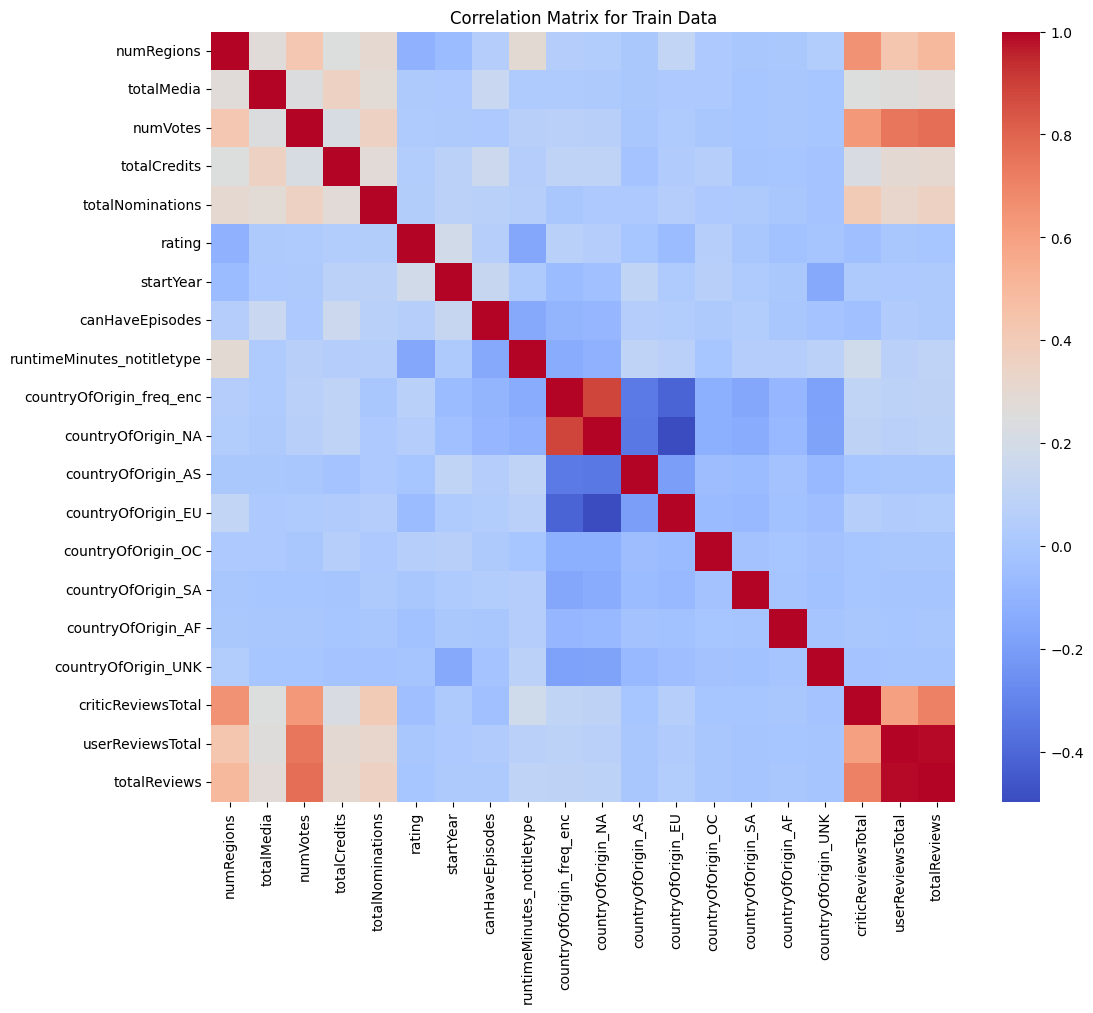

In [105]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = train[corr_matr_feats].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for Train Data')
plt.show()

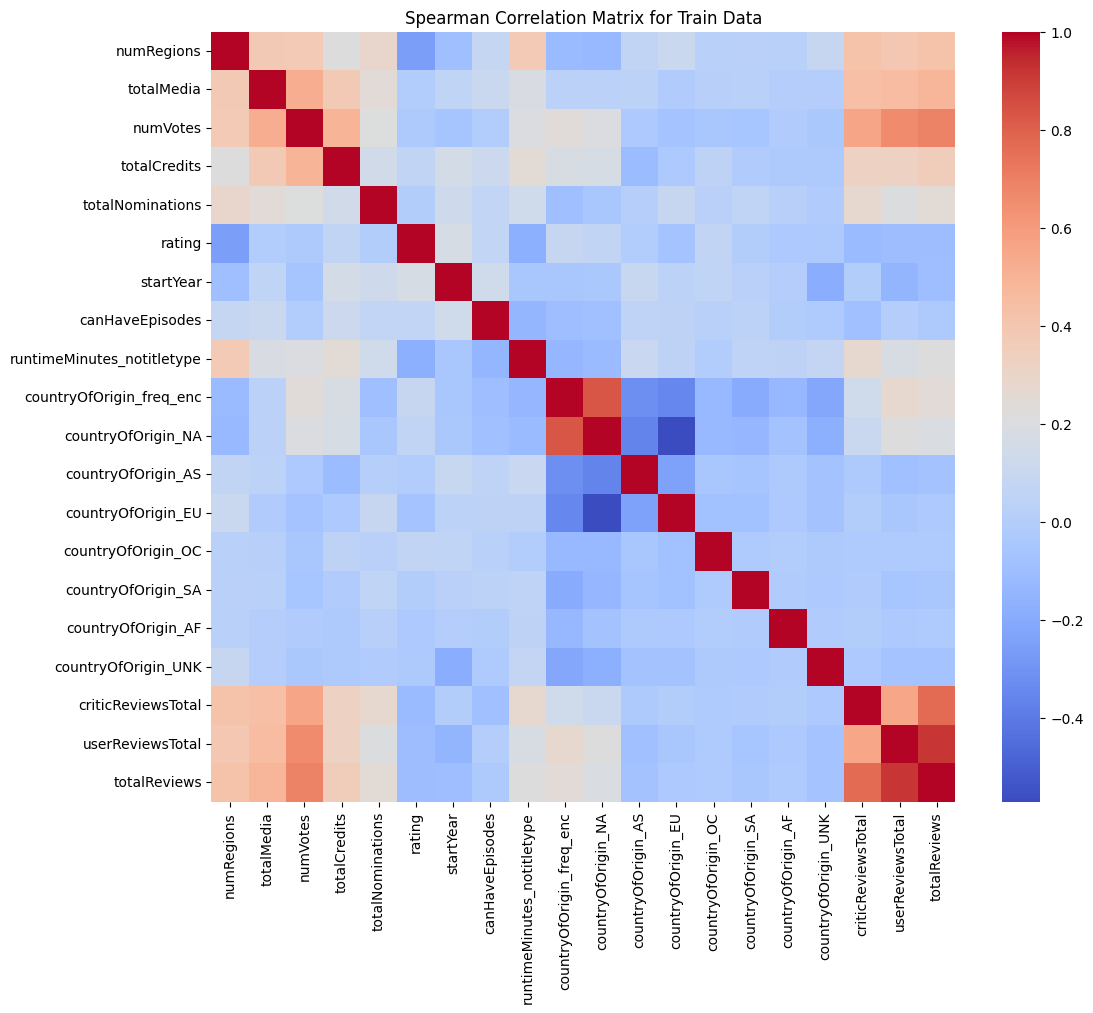

In [106]:
# Compute the Spearman correlation matrix
spearman_corr_matrix = train[corr_matr_feats].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Spearman Correlation Matrix for Train Data')
plt.show()

In [107]:
correlation_eu_na = train['countryOfOrigin_EU'].corr(train['countryOfOrigin_NA'])
print(f"Correlation between countryOfOrigin_EU and countryOfOrigin_NA: {correlation_eu_na}")

Correlation between countryOfOrigin_EU and countryOfOrigin_NA: -0.49711596064390473


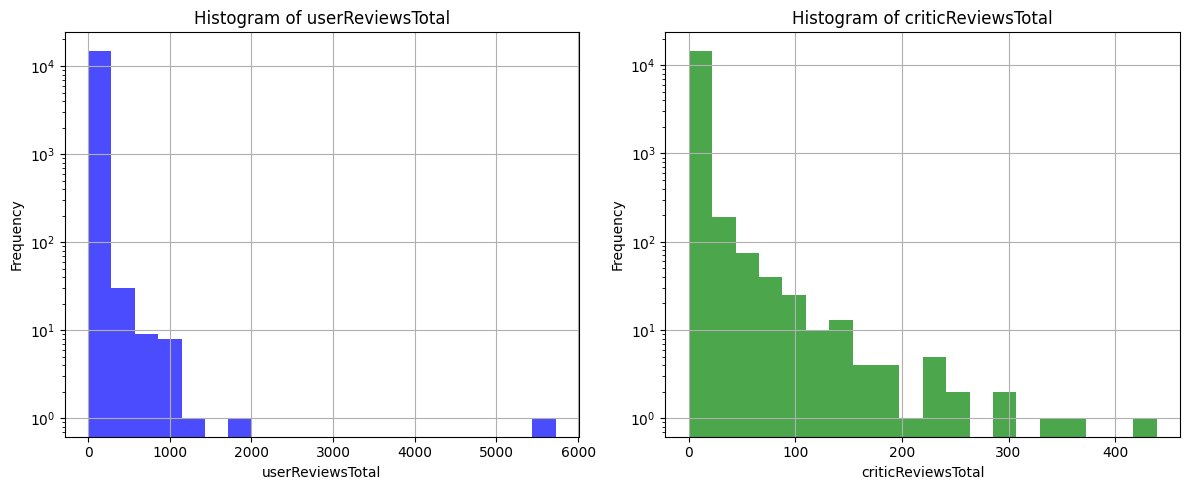

In [108]:
plt.figure(figsize=(12, 5))

# Histogram for countryOfOrigin_NA
plt.subplot(1, 2, 1)
train['userReviewsTotal'].hist(bins=20, color='blue', alpha=0.7)
plt.title('Histogram of userReviewsTotal')
plt.xlabel('userReviewsTotal')
plt.ylabel('Frequency')
plt.yscale('log')

# Histogram for countryOfOrigin_EU
plt.subplot(1, 2, 2)
train['criticReviewsTotal'].hist(bins=20, color='green', alpha=0.7)
plt.title('Histogram of criticReviewsTotal')
plt.xlabel('criticReviewsTotal')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.show()

In [109]:
import numpy as np

train['userReviewsTotal_log'] = np.log1p(train['userReviewsTotal'])
train['criticReviewsTotal_log'] = np.log1p(train['criticReviewsTotal'])

test['userReviewsTotal_log'] = np.log1p(test['userReviewsTotal'])
test['criticReviewsTotal_log'] = np.log1p(test['criticReviewsTotal'])

Train Mean Absolute Error: 3.0544167733228478
Train Mean Squared Error: 111.1981976329653
Train R-squared: 0.35726362700134096
Mean Absolute Error: 3.4187683254780588
Mean Squared Error: 189.54331325729277
R-squared: 0.4655022280225699
Intercept: 1.7596260327719293
Coefficients: [0.12601613]


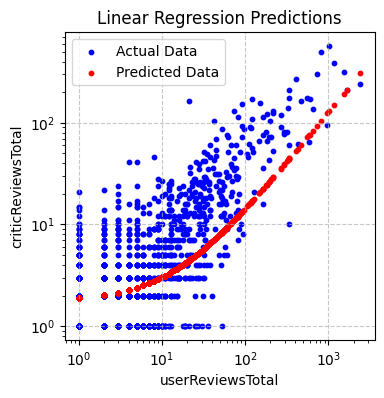

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def train_linear_regressor(train: pd.DataFrame, test: pd.DataFrame, log: bool=False,):
    # Define the train setnon mi toccate zion
    X_train = train['userReviewsTotal' if not log else 'userReviewsTotal_log'].values.reshape(-1, 1)
    y_train = train['criticReviewsTotal' if not log else 'criticReviewsTotal_log'].values

    # Define the test set
    X_test = test['userReviewsTotal' if not log else 'userReviewsTotal_log'].values.reshape(-1, 1)
    y_test = test['criticReviewsTotal'].values

    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse the log transformation
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    # print train mse, mae and r2
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    print(f"Train Mean Absolute Error: {mae_train}")
    
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    print(f"Mean Absolute Error: {mae}")
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print(f"Intercept: {model.intercept_}")
    print(f"Coefficients: {model.coef_}")

    # Plot test data and predictions
    plt.figure(figsize=(4, 4))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=10)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=10)
    plt.title('Linear Regression Predictions')
    plt.xlabel('userReviewsTotal')
    plt.ylabel('criticReviewsTotal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
train_linear_regressor(train, test, log=False)

In [111]:
# Calculate IQR for log-transformed criticReviewsTotal
q1_critic_log = train['criticReviewsTotal_log'].quantile(0.25)
q3_critic_log = train['criticReviewsTotal_log'].quantile(0.75)
iqr_critic_log = q3_critic_log - q1_critic_log

# Define lower and upper bounds for log-transformed criticReviewsTotal
lower_bound_critic_log = q1_critic_log - 1.5 * iqr_critic_log
upper_bound_critic_log = q3_critic_log + 1.5 * iqr_critic_log

# Calculate IQR for log-transformed userReviewsTotal
q1_user_log = train['userReviewsTotal_log'].quantile(0.25)
q3_user_log = train['userReviewsTotal_log'].quantile(0.75)
iqr_user_log = q3_user_log - q1_user_log

# Define lower and upper bounds for log-transformed userReviewsTotal
lower_bound_user_log = q1_user_log - 1.5 * iqr_user_log
upper_bound_user_log = q3_user_log + 1.5 * iqr_user_log

# Filter rows within the bounds for log-transformed criticReviewsTotal
train_trimmed_log = train[
    (train['criticReviewsTotal_log'] >= lower_bound_critic_log) &
    (train['criticReviewsTotal_log'] <= upper_bound_critic_log) &
    (train['userReviewsTotal_log'] >= lower_bound_user_log) &
    (train['userReviewsTotal_log'] <= upper_bound_user_log)]

# Reset index and display the updated train DataFrame
train.reset_index(drop=True, inplace=True)

Train Mean Absolute Error: 0.33030480385624644
Train Mean Squared Error: 0.2415995123564857
Train R-squared: 0.0698221816149106
Mean Absolute Error: 2.53018260125974
Mean Squared Error: 197.2417825958558
R-squared: 0.4437931281952765
Intercept: 0.14014772673181158
Coefficients: [0.12194476]


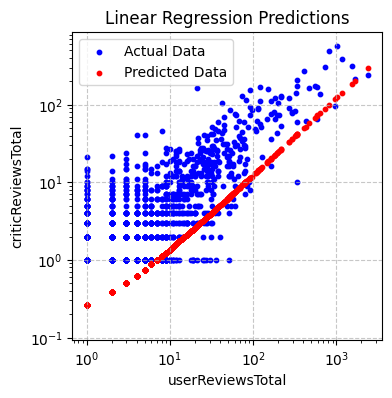

In [112]:
# Calculate IQR for log-transformed criticReviewsTotal
q1_critic_log = train['criticReviewsTotal'].quantile(0.25)
q3_critic_log = train['criticReviewsTotal'].quantile(0.75)
iqr_critic_log = q3_critic_log - q1_critic_log

# Define lower and upper bounds for log-transformed criticReviewsTotal
lower_bound_critic_log = q1_critic_log - 1.5 * iqr_critic_log
upper_bound_critic_log = q3_critic_log + 1.5 * iqr_critic_log

# Calculate IQR for log-transformed userReviewsTotal
q1_user_log = train['userReviewsTotal'].quantile(0.25)
q3_user_log = train['userReviewsTotal'].quantile(0.75)
iqr_user_log = q3_user_log - q1_user_log

# Define lower and upper bounds for log-transformed userReviewsTotal
lower_bound_user_log = q1_user_log - 1.5 * iqr_user_log
upper_bound_user_log = q3_user_log + 1.5 * iqr_user_log

# Filter rows within the bounds for log-transformed criticReviewsTotal
train_trimmed = train[
    (train['criticReviewsTotal'] >= lower_bound_critic_log) &
    (train['criticReviewsTotal'] <= upper_bound_critic_log) &
    (train['userReviewsTotal'] >= lower_bound_user_log) &
    (train['userReviewsTotal'] <= upper_bound_user_log)]

# Reset index and display the updated train DataFrame
train.reset_index(drop=True, inplace=True)

train_linear_regressor(train_trimmed, test, log=False)

# Ridge

Train Mean Absolute Error: 3.0544167867468874
Train Mean Squared Error: 111.19819763296532
Train R-squared: 0.35726362700134084
Mean Absolute Error: 3.418768341510223
Mean Squared Error: 189.5433150384084
R-squared: 0.4655022229999588


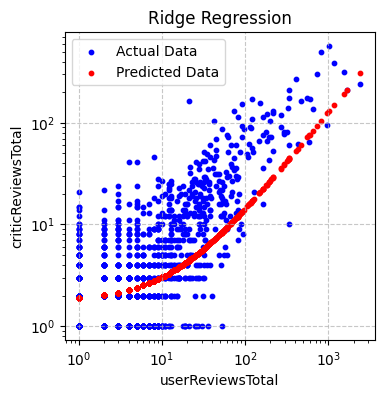

In [113]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

def train_ridge_lasso_regressor(train, test, log=False, model_type='ridge', alpha=1.0):
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the model
    if model_type.lower() == 'ridge':
        model = Ridge(alpha=alpha)
    elif model_type.lower() == 'lasso':
        model = Lasso(alpha=alpha)
    else:
        raise ValueError("Invalid model_type. Choose 'ridge' or 'lasso'.")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    # Print train mse, mae and r^2
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Absolute Error: {mae_train}")
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Plot test data and predictions
    plt.figure(figsize=(4, 4))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=10)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=10)
    plt.title(f'{model_type.capitalize()} Regression' + (' (Log)' if log else ''))
    plt.xlabel('userReviewsTotal')
    plt.ylabel('criticReviewsTotal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

# Example usage
train_ridge_lasso_regressor(train, test, log=False, model_type='ridge', alpha=1.0)

# Lasso

Train Mean Absolute Error: 3.0560098754648193
Train Mean Squared Error: 111.19845455338326
Train R-squared: 0.3572621419763936
Mean Absolute Error: 3.420670947583885
Mean Squared Error: 189.7549443808646
R-squared: 0.4649054443002305


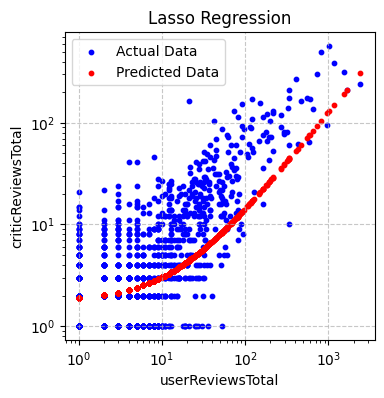

In [114]:
train_ridge_lasso_regressor(train, test, log=False, model_type='Lasso', alpha=1.0)

# DT

Train Mean Absolute Error: 1.6112076026202498
Train Mean Squared Error: 22.609256883619086
Train R-squared: 0.8693163012089661
Mean Absolute Error: 2.5656458511987967
Mean Squared Error: 189.3755004577299
R-squared: 0.46597544739356334


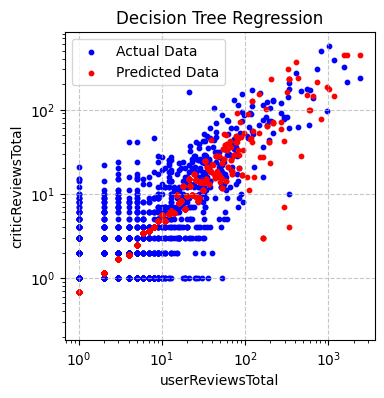

In [115]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
import matplotlib.pyplot as plt

def train_dt_regressor(train, test, log=False, param_distributions=None, n_iter=30, cv=3, random_state=42):
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=random_state,
                                     criterion='squared_error',)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    # Perform RandomizedSearchCV if param_distributions is provided
    if param_distributions:
        random_search = RandomizedSearchCV(
            estimator=dt_model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=cv,
            scoring='neg_mean_squared_error',
            random_state=random_state,
            n_jobs=-1
        )
        random_search.fit(X_train, y_train)
        dt_model = random_search.best_estimator_
        print(f"Best Parameters: {random_search.best_params_}")

    # Train the model
    dt_model.fit(X_train, y_train)

    y_train_pred = dt_model.predict(X_train)

    # Make predictions
    y_pred = dt_model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)
        y_train_pred = np.expm1(y_train_pred)

    # Print train mse, mae and r^2
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Absolute Error: {mae_train}")
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    print(f"Mean Absolute Error: {mae}")
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Plot test data and predictions
    plt.figure(figsize=(4, 4))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=10)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=10)
    plt.title('Decision Tree Regression' + (' (Log)' if log else ''))
    plt.xlabel('userReviewsTotal')
    plt.ylabel('criticReviewsTotal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
train_dt_regressor(train, test, log=False)

Best Parameters: {'ccp_alpha': 0.07533781852589416, 'criterion': 'friedman_mse', 'max_depth': 18, 'max_leaf_nodes': 12, 'min_impurity_decrease': 0.05584042497358051, 'min_samples_leaf': 10, 'min_samples_split': 20}
Train Mean Absolute Error: 2.0177472393205504
Train Mean Squared Error: 55.694467336256324
Train R-squared: 0.6780805742018114
Mean Absolute Error: 2.2370085912722373
Mean Squared Error: 110.19109820201797
R-squared: 0.6892694578954832


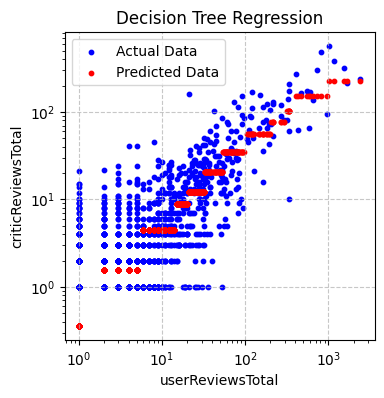

In [116]:
from scipy.stats import uniform

param_distributions = {
    'max_depth': [None] + list(range(1, 21)),  # None or depths from 1 to 20
    'min_samples_split': list(range(2, 21)),      # Minimum samples required to split an internal node
    'min_samples_leaf': list(range(1, 21)),       # Minimum samples required to be at a leaf node
    # 'max_features': ['auto', 'sqrt', 'log2'],      # Number of features to consider when looking for the best split
    'max_leaf_nodes': [None] + list(range(2, 21)),  # Number of leaf nodes
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],  # Minimum weighted fraction of the sum total of weights
    'min_impurity_decrease': uniform(0.0, 0.1),  # Minimum impurity decrease required to split a node
    'criterion': ['squared_error', 'friedman_mse'],  # Splitting criteria
    'ccp_alpha': uniform(0.0, 0.1)  # Complexity parameter for Minimal Cost-Complexity Pruning
}

train_dt_regressor(train, test, log=False, param_distributions=param_distributions, n_iter=200, cv=5)

# KNN

Train Mean Absolute Error: 2.054028752925443
Train Mean Squared Error: 53.26122367101305
Train R-squared: 0.6921449587090365
Mean Absolute Error: 2.4638537271448664
Mean Squared Error: 129.29604982921438
R-squared: 0.6353949428678203


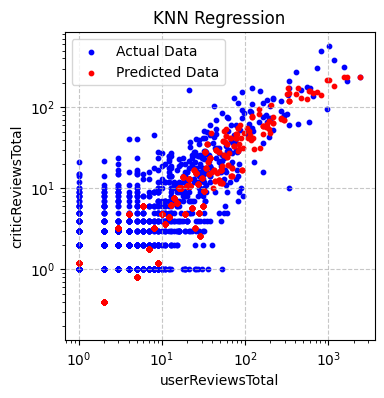

KNeighborsRegressor()

In [117]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

def train_knn_regressor(train, test, log=False, n_neighbors=5) -> KNeighborsRegressor:
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the KNN Regressor
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

    # Train the model
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_pred = knn_model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    # print train mse, mae and r^2
    y_train_pred = knn_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Absolute Error: {mae_train}")
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Plot test data and predictions
    plt.figure(figsize=(4, 4))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=10)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=10)
    plt.title('KNN Regression' + (' (Log)' if log else ''))
    plt.xlabel('userReviewsTotal')
    plt.ylabel('criticReviewsTotal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    return knn_model

# Example usage
train_knn_regressor(train, test, log=False, n_neighbors=5)

Training KNN with k=1
Training KNN with k=2
Training KNN with k=3
Training KNN with k=4
Training KNN with k=5
Training KNN with k=6
Training KNN with k=7
Training KNN with k=8
Training KNN with k=9
Training KNN with k=10


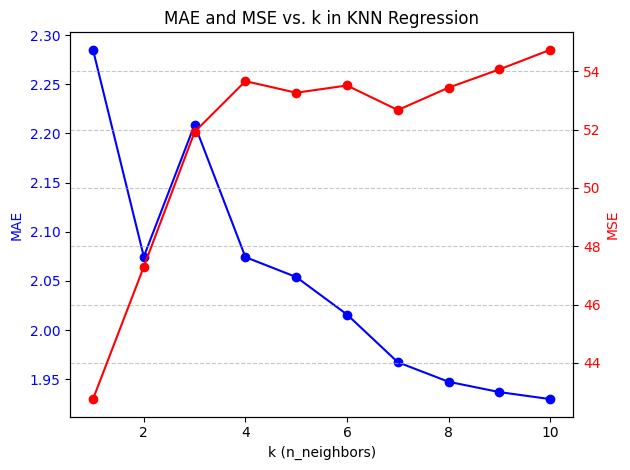

In [118]:
# Define a range of k values
k_values = range(1, 11)
mae_values = []
mse_values = []

def train_knn_regressor_mae_mse(train, test, log=False, n_neighbors=5):
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the KNN Regressor
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

    # Train the model
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_pred = knn_model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    train_mse = mean_squared_error(y_train, knn_model.predict(X_train))
    train_mae = np.mean(np.abs(y_train - knn_model.predict(X_train)))
    # Evaluate the model
    test_mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    test_mae = np.mean(np.abs(y_test - y_pred))
    
    return train_mse, train_mae, test_mse, test_mae

# Train KNN regressors for each k and calculate MAE
for k in k_values:
    print(f"Training KNN with k={k}")
    train_mse, train_mae, _, _ = train_knn_regressor_mae_mse(train, test, log=False, n_neighbors=k)
    
    mae_values.append(train_mae)
    mse_values.append(train_mse)

# Now plot using twinx
fig, ax1 = plt.subplots()

ax1.plot(k_values, mae_values, 'b-o', label='MAE')
ax1.set_xlabel('k (n_neighbors)')
ax1.set_ylabel('MAE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_values, mse_values, 'r-o', label='MSE')
ax2.set_ylabel('MSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('MAE and MSE vs. k in KNN Regression')
plt.grid(linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

Training KNN with k=1
Training KNN with k=2
Training KNN with k=3
Training KNN with k=4
Training KNN with k=5
Training KNN with k=6
Training KNN with k=7
Training KNN with k=8
Training KNN with k=9
Training KNN with k=10


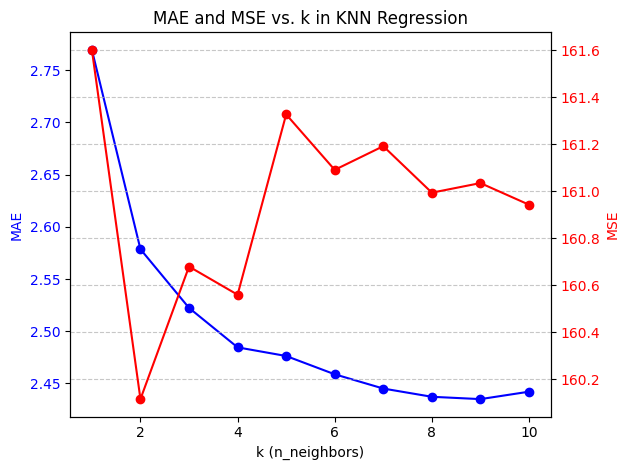

In [119]:
mae_values = []
mse_values = []

# Train KNN regressors for each k and calculate MAE
for k in k_values:
    print(f"Training KNN with k={k}")
    mse, mae, _, _ = train_knn_regressor_mae_mse(train, test, log=True, n_neighbors=k)
    
    mae_values.append(mae)
    mse_values.append(mse)

# Now plot using twinx
fig, ax1 = plt.subplots()

ax1.plot(k_values, mae_values, 'b-o', label='MAE')
ax1.set_xlabel('k (n_neighbors)')
ax1.set_ylabel('MAE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_values, mse_values, 'r-o', label='MSE')
ax2.set_ylabel('MSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('MAE and MSE vs. k in KNN Regression')
plt.grid(linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()